In [32]:
import matplotlib
import pandas as pd
import re
import urllib.request

draft_url = 'http://dolphinsim.com/clmanager/epbl/index_dra.shtml'
%matplotlib inline

pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

POS_FACTOR = 15
POT_FACTOR = 1
STAT_FACTOR = 12
CO_MIN = 5
ARM_MIN = 3
DS_MIN = 2
PIT_MIN = 6

def attr_score(val, factor):
    return (val//factor)**2

def stat_score(df, in_col, out_col, multiplier=1):
    in_min = df[in_col].min()
    in_max = df[in_col].max()
    df[in_col] = df[in_col].apply(lambda x: x - in_min)
    factor = (in_max - in_min) // 25
    df[out_col] = df[in_col].apply(lambda x: attr_score(x, factor) * multiplier)
    return df

In [2]:
draft_page_response = urllib.request.urlopen(draft_url)
draft_page = draft_page_response.read()
draft_page_response.close()

In [3]:
pre_blocks = draft_page.__str__().split('<pre>')[4:]
words_regex = re.compile('\s+')
block_names = ['BAT', 'PIT', 'ATT']
df_dict = {}
for pre_block, block_name in zip(pre_blocks, block_names):
    pre_block = pre_block.split('</pre>')[0].split('\\n')
    columns = None
    player_dict = {}
    for player in pre_block:
        player = player.strip()
        if len(player) == 0:
            continue
        player = words_regex.split(player)
        if columns is None:
            columns = player
            if columns[-1] == 'H':
                columns[-1] = 'Hnd'
            for column in columns:
                player_dict[column] = []
            #print('{0} Columns {1}: {2}'.format(block_name, columns[0], ', '.join(columns[1:])))
            continue
        #print('{0} Player {1}: {2}'.format(block_name, player[0], ', '.join(player[1:])))
        for column, value in zip(columns, player):
            player_dict[column].append(value)
    
    #for column in player_dict.keys():
    #    print('{0}: {1} values'.format(column, len(player_dict[column])))
    df_dict[block_name] = pd.DataFrame(data=player_dict).set_index(columns[0])
    
df = None
prev_block_name = None
for block_name in block_names:
    part_df = df_dict[block_name]
    if df is None:
        df = part_df
        prev_block_name = block_name
    else:
        df = df.join(part_df, rsuffix='_' + block_name)

df = df.drop(['Name_PIT', 'Name_ATT', 'Ps_ATT', 'In', 'Rnk'], axis=1)
rename_dict = dict(zip(['BB', 'H', 'HR', 'SO', 'Hnd', 'OBP'], ['BB_BAT', 'H_BAT', 'HR_BAT', 'SO_BAT', 'Hnd_BAT', 'OBP_PIT']))
df = df.rename(columns=rename_dict)
print(df.columns)

Index(['2B', '3B', 'AB', 'Avg', 'BB_BAT', 'E', 'H_BAT', 'HR_BAT', 'Hnd_BAT',
       'Name', 'PA', 'PM', 'Ps', 'RBI', 'SB', 'SBA', 'SO_BAT', 'BB_PIT', 'BS',
       'Bt', 'ER', 'ERA', 'G', 'H_PIT', 'HR_PIT', 'Hnd_PIT', 'IP', 'L',
       'OBP_PIT', 'SO_PIT', 'SV', 'St', 'W', 'Ag', 'Ar', 'BH', 'Cn', 'Co',
       'Df', 'Dr', 'Ds', 'GP', 'PH', 'Pw', 'Rst', 'Sp', 'St_ATT', 'Tr'],
      dtype='object')


In [4]:
attrs = ['Dr', 'Ds', 'Sp', 'Co', 'Pw', 'Df', 'Ar', 'Cn']
scored=df
pos_weight = 15
stat_weight = 15
pot_weight = 10
for attr in attrs:
    attr_col = attr + '_score'
    scored[attr_col] = scored[attr].apply(lambda x: attr_score(int(x),2))
scored['Stat_raw'] = 0
scored['Stat_score'] = 0
scored['Ps_raw'] = 0
scored['Ps_score'] = 0
scored['Group'] = 0

scored['AB'] = scored['AB'].astype(int)
scored['BB_BAT'] = scored['BB_BAT'].astype(int)
scored['AB_avg'] = scored['AB'] + scored['BB_BAT']
scored = stat_score(scored, 'AB_avg', 'AB_score')

scored['GP'] = scored['GP'].astype(int)
scored = stat_score(scored, 'GP', 'GP_score')
   
scored['Tr_score'] = scored['Tr'].apply(lambda x: attr_score(50-int(x)-25, 8))
scored['Ag_score'] = scored['Ag'].apply(lambda x: attr_score(23-int(x[:2]), 1))
scored['Pot_raw'] = (scored['Tr_score'] + scored['Ag_score'])
scored = stat_score(scored, 'Pot_raw', 'Pot_score', pot_weight)

scored['K_BAT'] = (1 - (scored['SO_BAT'].astype(int) / (scored['AB'].astype(int) + scored['BB_BAT'].astype(int)))) * 1000
scored['K_BAT'] = scored['K_BAT'].apply(lambda x: 0 if str(x) == 'nan' else x)
scored = stat_score(scored, 'K_BAT', 'K_score')

scored['AB_score'] = scored['AB'].astype(int).apply(lambda x: 150 if x < 150 else x)
scored['OBP_BAT'] = ((scored['H_BAT'].astype(int) + scored['BB_BAT'].astype(int)) / \
                    (scored['AB_score'] + scored['BB_BAT'].astype(int))) * 1000
scored['OBP_BAT'] = scored['OBP_BAT'].apply(lambda x: 0.00 if str(x) == 'nan' else x)
scored = stat_score(scored, 'OBP_BAT', 'OBP_score')

scored['SB'] = scored['SB'].astype(int)
scored = stat_score(scored, 'SB', 'SB_score')

scored['TB'] = scored['H_BAT'].astype(int) + scored['2B'].astype(int) + scored['3B'].astype(int) * 2 \
                + scored['HR_BAT'].astype(int) * 3
scored['SLG'] = (scored['TB'] / scored['AB_score']) * 1000
scored = stat_score(scored, 'SLG', 'SLG_score')

scored['OPS'] = (scored['TB'] / scored['AB'].astype(int)) + ((scored['H_BAT'].astype(int) +  \
                                                              scored['BB_BAT'].astype(int)) / \
                                                             (scored['AB'].astype(int) + \
                                                              scored['BB_BAT'].astype(int))) * 1000
scored = stat_score(scored, 'OPS', 'OPS_score')

scored['RC'] = (((scored['H_BAT'].astype(int) + scored['BB_BAT'].astype(int) - \
                  (scored['SBA'].astype(int) - scored['SB'].astype(int))) * \
                  (scored['TB'] + (0.55 * scored['SB'].astype(int)))) / \
                (scored['AB'].astype(int) + scored['BB_BAT'].astype(int)))
scored = stat_score(scored, 'RC', 'RC_score')

scored['AVG_BAT'] = (scored['H_BAT'].astype(int) / scored['AB_score']) * 1000
scored['AVG_BAT'] = scored['AVG_BAT'].apply(lambda x: 0.00 if str(x) == 'nan' else x)
scored = stat_score(scored, 'AVG_BAT', 'AVG_score')

scored.sort_values(by=['RC_score', 'OPS_score', 'Pot_score', 'OBP_score', 'AVG_score', 'SLG_score', 'SB_score', 'K_score', 'OBP_BAT', 'K_BAT'], ascending=False).loc[:, ['RC_score', 'RC', 'OPS_score', 'OPS', 'Pot_score', 'Ag', 'Tr', 'Tr_score', 'GP_score', 'GP', 'AB_score', 'AB', 'BB_BAT', 'OBP_score', 'AVG_score', 'SLG_score', 'SB_score', 'K_score']]

,RC_score,RC,OPS_score,OPS,Pot_score,Ag,Tr,Tr_score,GP_score,GP,AB_score,AB,BB_BAT,OBP_score,AVG_score,SLG_score,SB_score,K_score
Num,,,,,,,,,,,,,,,,,,
5749,841.0,116.322222,256.0,503.961891,10,22r,12,1,1225,70,265,265,59,529.0,576.0,625.0,841,529.0
3270,676.0,104.729808,256.0,481.590524,160,21r,12,1,1296,72,263,263,49,484.0,576.0,529.0,36,529.0
218,625.0,100.850749,256.0,482.738631,1440,20r,8,4,1225,71,296,296,38,484.0,625.0,400.0,49,484.0
1747,625.0,102.345593,256.0,502.253570,810,20r,13,1,1296,72,278,278,51,529.0,625.0,400.0,49,529.0
5919,625.0,101.436336,225.0,463.215040,160,21r,15,1,1225,71,291,291,42,484.0,576.0,441.0,196,484.0
5836,576.0,97.901153,196.0,444.563110,10,22r,15,1,1369,74,303,303,44,441.0,484.0,441.0,4,529.0
5562,529.0,93.298160,225.0,476.183759,810,20r,14,1,1225,70,275,275,51,484.0,529.0,400.0,4,484.0
1486,529.0,95.060751,225.0,478.625617,0,22r,19,0,1296,72,242,242,51,484.0,484.0,529.0,256,529.0
4236,484.0,88.436416,196.0,442.888057,810,20r,13,1,1296,73,295,295,51,441.0,441.0,361.0,25,529.0


In [5]:
catchers = scored[scored['Ps'] == 'C']
infielders = scored[scored['Ps'] == 'IF']
corner_infielders = infielders[infielders['Df'] < '3']
first_basemen = corner_infielders[corner_infielders['Ar'] < '3']
third_basemen = corner_infielders[corner_infielders['Ar'] >= '3']
middle_infielders = infielders[infielders['Df'] >= '3']
second_basemen = middle_infielders[middle_infielders['Ar'] < '3']
shortstops = middle_infielders[middle_infielders['Ar'] >= '3']
outfielders = scored[scored['Ps'] == 'OF']
edge_outfielders = outfielders[outfielders['Df'] < '3']
right_fielders = edge_outfielders[edge_outfielders['Ar'] < '3']
left_fielders = edge_outfielders[edge_outfielders['Ar'] >= '3']
center_fielders = outfielders[outfielders['Df'] >= '3']
pitchers = scored[scored['Ps'] == 'P']
starting_pitchers = pitchers[pitchers['Dr'] >= '5']
relief_pitchers = pitchers[pitchers['Dr'] < '5']

print('{0:3d} catchers'.format(len(catchers)))
print('{0:3d} first basemen'.format(len(first_basemen)))
print('{0:3d} second basemen'.format(len(second_basemen)))
print('{0:3d} shortstops'.format(len(shortstops)))
print('{0:3d} third basemen'.format(len(third_basemen)))
print('{0:3d} right fielders'.format(len(right_fielders)))
print('{0:3d} center fielders'.format(len(center_fielders)))
print('{0:3d} left fielders'.format(len(left_fielders)))
print('{0:3d} starting pitchers'.format(len(starting_pitchers)))
print('{0:3d} relief_pitchers'.format(len(relief_pitchers)))

150 catchers
183 first basemen
116 second basemen
 67 shortstops
 84 third basemen
166 right fielders
134 center fielders
 75 left fielders
357 starting pitchers
468 relief_pitchers


In [6]:
def min_hit(x):
    if int(x['Co']) >= CO_MIN and int(x['Ds']) >= DS_MIN:
        return x['Ps_raw']
    else:
        return -1000

def min_arm(x):
    if int(x['Ar']) >= ARM_MIN:
        return x['Ps_raw']
    else:
        return -1000
    
def min_pit(x):
    if int(x['Ar']) + int(x['Cn']) >= PIT_MIN:
        return x['Ps_raw']
    else:
        return -1000

In [7]:
catchers['Ps_raw'] = catchers['Co_score'] * 8 + catchers['Pw_score'] * 3 + catchers['Ds_score'] * 6 + \
                     catchers['Ar_score'] * 6 + catchers['Dr_score'] + catchers['Sp_score'] + catchers['Df_score']  
catchers['Ps_raw'] = catchers.apply(min_hit, axis=1)
catchers['Ps_raw'] = catchers.apply(min_arm, axis=1)
catchers = stat_score(catchers, 'Ps_raw', 'Ps_score', pos_weight)
catchers['PA_avg'] = (1 - (catchers['PA'].astype(int) / catchers['AB'].astype(int))) * 1000
catchers['PA_avg'] = catchers['PA_avg'].apply(lambda x: 0 if str(x) == 'nan' else x)
catchers = stat_score(catchers, 'PA_avg', 'PA_score')
catchers['PM_avg'] = (1 - (catchers['PM'].astype(int) / catchers['AB'].astype(int))) * 1000
catchers['PM_avg'] = catchers['PM_avg'].apply(lambda x: 0 if str(x) == 'nan' else x)
catchers = stat_score(catchers, 'PM_avg', 'PM_score')
catchers['E_avg'] = (1 - (catchers['E'].astype(int) / catchers['PA'].astype(int))) * 1000
catchers['E_avg'] = catchers['E_avg'].apply(lambda x: 0 if str(x) == 'nan' else x)
catchers = stat_score(catchers, 'E_avg', 'E_score')
catchers['Stat_raw'] = (catchers['RC_score'] * 16 + \
                         catchers['OPS_score'] * 4 + \
                         catchers['OBP_score'] * 2 + \
                         catchers['PA_score'] * 2 + \
                         catchers['PM_score'] * 2 + \
                         catchers['E_score'] * 2 + \
                         catchers['SB_score'] + \
                         catchers['K_score']) * catchers['GP_score']
catchers['Group'] = '1'
catchers = stat_score(catchers, 'Stat_raw', 'Stat_score', stat_weight)

/home/jesse/miniconda3/envs/dolphinsim/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/jesse/miniconda3/envs/dolphinsim/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/jesse/miniconda3/envs/dolphinsim/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [8]:
first_basemen['Ps_raw'] = first_basemen['Co_score'] * 8 + first_basemen['Pw_score'] * 3 + first_basemen['Ds_score'] * 6 + \
                     first_basemen['Ar_score'] + first_basemen['Dr_score'] + first_basemen['Sp_score'] * 2 + \
                     first_basemen['Df_score'] * 2    
first_basemen['Ps_raw'] = first_basemen.apply(min_hit, axis=1)
first_basemen = stat_score(first_basemen, 'Ps_raw', 'Ps_score', pos_weight)
first_basemen['PA_avg'] = (first_basemen['PA'].astype(int) / first_basemen['AB'].astype(int)) * 1000
first_basemen['PA_avg'] = first_basemen['PA_avg'].apply(lambda x: 0 if str(x) == 'nan' else x)
first_basemen = stat_score(first_basemen, 'PA_avg', 'PA_score')
first_basemen['PM_avg'] = (first_basemen['PM'].astype(int) / first_basemen['AB'].astype(int)) * 1000
first_basemen['PM_avg'] = first_basemen['PM_avg'].apply(lambda x: 0 if str(x) == 'nan' else x)
first_basemen = stat_score(first_basemen, 'PM_avg', 'PM_score')
first_basemen['E_avg'] = (1 - (first_basemen['E'].astype(int) / first_basemen['PA'].astype(int))) * 1000
first_basemen['E_avg'] = first_basemen['E_avg'].apply(lambda x: 0 if str(x) == 'nan' else x)
first_basemen = stat_score(first_basemen, 'E_avg', 'E_score')
first_basemen['Stat_raw'] = (first_basemen['RC_score'] * 16 + \
                         first_basemen['OPS_score'] * 4 + \
                         first_basemen['OBP_score'] * 2 + \
                         first_basemen['PA_score'] + \
                         first_basemen['PM_score'] + \
                         first_basemen['E_score'] + \
                         first_basemen['SB_score'] + \
                         first_basemen['K_score']) * first_basemen['GP_score']
first_basemen['Group'] = '2'
first_basemen = stat_score(first_basemen, 'Stat_raw', 'Stat_score', stat_weight)

/home/jesse/miniconda3/envs/dolphinsim/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/jesse/miniconda3/envs/dolphinsim/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/jesse/miniconda3/envs/dolphinsim/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [9]:
second_basemen['Ps_raw'] = second_basemen['Co_score'] * 8 + second_basemen['Pw_score'] * 3 + second_basemen['Ds_score'] * 6 + \
                     second_basemen['Ar_score'] + second_basemen['Dr_score'] + second_basemen['Sp_score'] * 2 + \
                     second_basemen['Df_score'] * 2    
second_basemen['Ps_raw'] = second_basemen.apply(min_hit, axis=1)
second_basemen = stat_score(second_basemen, 'Ps_raw', 'Ps_score', pos_weight)
second_basemen['PA_avg'] = (second_basemen['PA'].astype(int) / second_basemen['AB'].astype(int)) * 1000
second_basemen['PA_avg'] = second_basemen['PA_avg'].apply(lambda x: 0 if str(x) == 'nan' else x)
second_basemen = stat_score(second_basemen, 'PA_avg', 'PA_score')
second_basemen['PM_avg'] = (second_basemen['PM'].astype(int) / second_basemen['AB'].astype(int)) * 1000
second_basemen['PM_avg'] = second_basemen['PM_avg'].apply(lambda x: 0 if str(x) == 'nan' else x)
second_basemen = stat_score(second_basemen, 'PM_avg', 'PM_score')
second_basemen['E_avg'] = (1 - (second_basemen['E'].astype(int) / second_basemen['PA'].astype(int))) * 1000
second_basemen['E_avg'] = second_basemen['E_avg'].apply(lambda x: 0 if str(x) == 'nan' else x)
second_basemen = stat_score(second_basemen, 'E_avg', 'E_score')
second_basemen['Stat_raw'] = (second_basemen['RC_score'] * 14 + \
                         second_basemen['OPS_score'] * 3 + \
                         second_basemen['OBP_score'] * 2 + \
                         second_basemen['PA_score'] * 2 + \
                         second_basemen['PM_score'] * 2 + \
                         second_basemen['E_score'] * 2 + \
                         second_basemen['SB_score'] + \
                         second_basemen['K_score']) * second_basemen['GP_score']
second_basemen['Group'] = '3'
second_basemen = stat_score(second_basemen, 'Stat_raw', 'Stat_score', stat_weight)

/home/jesse/miniconda3/envs/dolphinsim/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/jesse/miniconda3/envs/dolphinsim/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/jesse/miniconda3/envs/dolphinsim/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [10]:
shortstops['Ps_raw'] = shortstops['Co_score'] * 8 + shortstops['Pw_score'] * 3 + shortstops['Ds_score'] * 6 + \
                     shortstops['Ar_score'] + shortstops['Dr_score'] + shortstops['Sp_score'] * 2 + \
                     shortstops['Df_score'] * 2    
shortstops['Ps_raw'] = shortstops.apply(min_hit, axis=1)
shortstops = stat_score(shortstops, 'Ps_raw', 'Ps_score', pos_weight)
shortstops['PA_avg'] = (shortstops['PA'].astype(int) / shortstops['AB'].astype(int)) * 1000
shortstops['PA_avg'] = shortstops['PA_avg'].apply(lambda x: 0 if str(x) == 'nan' else x)
shortstops = stat_score(shortstops, 'PA_avg', 'PA_score')
shortstops['PM_avg'] = (shortstops['PM'].astype(int) / shortstops['AB'].astype(int)) * 1000
shortstops['PM_avg'] = shortstops['PM_avg'].apply(lambda x: 0 if str(x) == 'nan' else x)
shortstops = stat_score(shortstops, 'PM_avg', 'PM_score')
shortstops['E_avg'] = (1 - (shortstops['E'].astype(int) / shortstops['PA'].astype(int))) * 1000
shortstops['E_avg'] = shortstops['E_avg'].apply(lambda x: 0 if str(x) == 'nan' else x)
shortstops = stat_score(shortstops, 'E_avg', 'E_score')
shortstops['Stat_raw'] = (shortstops['RC_score'] * 12 + \
                         shortstops['OPS_score'] * 3 + \
                         shortstops['OBP_score'] * 2 + \
                         shortstops['PA_score'] * 3 + \
                         shortstops['PM_score'] * 3 + \
                         shortstops['E_score'] * 3 + \
                         shortstops['SB_score'] + \
                         shortstops['K_score']) * shortstops['GP_score']
shortstops['Group'] = '4'
shortstops = stat_score(shortstops, 'Stat_raw', 'Stat_score', stat_weight)

/home/jesse/miniconda3/envs/dolphinsim/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/jesse/miniconda3/envs/dolphinsim/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/jesse/miniconda3/envs/dolphinsim/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [11]:
third_basemen['Ps_raw'] = third_basemen['Co_score'] * 8 + third_basemen['Pw_score'] * 3 + third_basemen['Ds_score'] * 6 + \
                     third_basemen['Ar_score'] + third_basemen['Dr_score'] + third_basemen['Sp_score'] * 2 + \
                     third_basemen['Df_score'] * 2    
third_basemen['Ps_raw'] = third_basemen.apply(min_hit, axis=1)
third_basemen = stat_score(third_basemen, 'Ps_raw', 'Ps_score', pos_weight)
third_basemen['PA_avg'] = (third_basemen['PA'].astype(int) / third_basemen['AB'].astype(int)) * 1000
third_basemen['PA_avg'] = third_basemen['PA_avg'].apply(lambda x: 0 if str(x) == 'nan' else x)
third_basemen = stat_score(third_basemen, 'PA_avg', 'PA_score')
third_basemen['PM_avg'] = (third_basemen['PM'].astype(int) / third_basemen['AB'].astype(int)) * 1000
third_basemen['PM_avg'] = third_basemen['PM_avg'].apply(lambda x: 0 if str(x) == 'nan' else x)
third_basemen = stat_score(third_basemen, 'PM_avg', 'PM_score')
third_basemen['E_avg'] = (1 - (third_basemen['E'].astype(int) / third_basemen['PA'].astype(int))) * 1000
third_basemen['E_avg'] = third_basemen['E_avg'].apply(lambda x: 0 if str(x) == 'nan' else x)
third_basemen = stat_score(third_basemen, 'E_avg', 'E_score')
third_basemen['Stat_raw'] = (third_basemen['RC_score'] * 16 + \
                         third_basemen['OPS_score'] * 4 + \
                         third_basemen['OBP_score'] * 2 + \
                         third_basemen['PA_score'] * 2 + \
                         third_basemen['PM_score'] * 2 + \
                         third_basemen['E_score'] * 2 + \
                         third_basemen['SB_score'] + \
                         third_basemen['K_score']) * third_basemen['GP_score']
third_basemen['Group'] = '5'
third_basemen = stat_score(third_basemen, 'Stat_raw', 'Stat_score', stat_weight)

/home/jesse/miniconda3/envs/dolphinsim/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/jesse/miniconda3/envs/dolphinsim/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/jesse/miniconda3/envs/dolphinsim/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [12]:
right_fielders['Ps_raw'] = right_fielders['Co_score'] * 8 + right_fielders['Pw_score'] * 3 + right_fielders['Ds_score'] * 6 + \
                     right_fielders['Ar_score'] * 2 + right_fielders['Dr_score'] + right_fielders['Sp_score'] * 2 + \
                     right_fielders['Df_score'] * 3
right_fielders['Ps_raw'] = right_fielders.apply(min_hit, axis=1)
right_fielders = stat_score(right_fielders, 'Ps_raw', 'Ps_score', pos_weight)
right_fielders['PA_avg'] = (right_fielders['PA'].astype(int) / right_fielders['AB'].astype(int)) * 1000
right_fielders['PA_avg'] = right_fielders['PA_avg'].apply(lambda x: 0 if str(x) == 'nan' else x)
right_fielders = stat_score(right_fielders, 'PA_avg', 'PA_score')
right_fielders['PM_avg'] = (right_fielders['PM'].astype(int) / right_fielders['AB'].astype(int)) * 1000
right_fielders['PM_avg'] = right_fielders['PM_avg'].apply(lambda x: 0 if str(x) == 'nan' else x)
right_fielders = stat_score(right_fielders, 'PM_avg', 'PM_score')
right_fielders['E_avg'] = (1 - (right_fielders['E'].astype(int) / right_fielders['PA'].astype(int))) * 1000
right_fielders['E_avg'] = right_fielders['E_avg'].apply(lambda x: 0 if str(x) == 'nan' else x)
right_fielders = stat_score(right_fielders, 'E_avg', 'E_score')
right_fielders['Stat_raw'] = (right_fielders['RC_score'] * 16 + \
                         right_fielders['OPS_score'] * 4 + \
                         right_fielders['OBP_score'] * 2 + \
                         right_fielders['PA_score'] * 1 + \
                         right_fielders['PM_score'] * 1 + \
                         right_fielders['E_score'] * 1 + \
                         right_fielders['SB_score'] + \
                         right_fielders['K_score']) * right_fielders['GP_score']
right_fielders['Group'] = '6'
right_fielders = stat_score(right_fielders, 'Stat_raw', 'Stat_score', stat_weight)

/home/jesse/miniconda3/envs/dolphinsim/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/jesse/miniconda3/envs/dolphinsim/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/jesse/miniconda3/envs/dolphinsim/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [14]:
left_fielders['Ps_raw'] = left_fielders['Co_score'] * 8 + left_fielders['Pw_score'] * 3 + left_fielders['Ds_score'] * 6 + \
                     left_fielders['Ar_score'] * 2 + left_fielders['Dr_score'] + left_fielders['Sp_score'] * 2 + \
                     left_fielders['Df_score'] * 3
left_fielders['Ps_raw'] = left_fielders.apply(min_hit, axis=1)
left_fielders = stat_score(left_fielders, 'Ps_raw', 'Ps_score', pos_weight)
left_fielders['PA_avg'] = (left_fielders['PA'].astype(int) / left_fielders['AB'].astype(int)) * 1000
left_fielders['PA_avg'] = left_fielders['PA_avg'].apply(lambda x: 0 if str(x) == 'nan' else x)
left_fielders = stat_score(left_fielders, 'PA_avg', 'PA_score')
left_fielders['PM_avg'] = (left_fielders['PM'].astype(int) / left_fielders['AB'].astype(int)) * 1000
left_fielders['PM_avg'] = left_fielders['PM_avg'].apply(lambda x: 0 if str(x) == 'nan' else x)
left_fielders = stat_score(left_fielders, 'PM_avg', 'PM_score')
left_fielders['E_avg'] = (1 - (left_fielders['E'].astype(int) / left_fielders['PA'].astype(int))) * 1000
left_fielders['E_avg'] = left_fielders['E_avg'].apply(lambda x: 0 if str(x) == 'nan' else x)
left_fielders = stat_score(left_fielders, 'E_avg', 'E_score')
left_fielders['Stat_raw'] = (left_fielders['RC_score'] * 16 + \
                         left_fielders['OPS_score'] * 4 + \
                         left_fielders['OBP_score'] * 2 + \
                         left_fielders['PA_score'] * 2 + \
                         left_fielders['PM_score'] * 2 + \
                         left_fielders['E_score'] * 2 + \
                         left_fielders['SB_score'] + \
                         left_fielders['K_score']) * left_fielders['GP_score']
left_fielders['Group'] = '7'
left_fielders = stat_score(left_fielders, 'Stat_raw', 'Stat_score', stat_weight)

/home/jesse/miniconda3/envs/dolphinsim/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/jesse/miniconda3/envs/dolphinsim/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/jesse/miniconda3/envs/dolphinsim/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [15]:
center_fielders['Ps_raw'] = center_fielders['Co_score'] * 8 + center_fielders['Pw_score'] * 3 + center_fielders['Ds_score'] * 6 + \
                     center_fielders['Ar_score'] * 2 + center_fielders['Dr_score'] + center_fielders['Sp_score'] * 2 + \
                     center_fielders['Df_score'] * 3
center_fielders['Ps_raw'] = center_fielders.apply(min_hit, axis=1)
center_fielders = stat_score(center_fielders, 'Ps_raw', 'Ps_score', pos_weight)
center_fielders['PA_avg'] = (center_fielders['PA'].astype(int) / center_fielders['AB'].astype(int)) * 1000
center_fielders['PA_avg'] = center_fielders['PA_avg'].apply(lambda x: 0 if str(x) == 'nan' else x)
center_fielders = stat_score(center_fielders, 'PA_avg', 'PA_score')
center_fielders['PM_avg'] = (center_fielders['PM'].astype(int) / center_fielders['AB'].astype(int)) * 1000
center_fielders['PM_avg'] = center_fielders['PM_avg'].apply(lambda x: 0 if str(x) == 'nan' else x)
center_fielders = stat_score(center_fielders, 'PM_avg', 'PM_score')
center_fielders['E_avg'] = (1 - (center_fielders['E'].astype(int) / center_fielders['PA'].astype(int))) * 1000
center_fielders['E_avg'] = center_fielders['E_avg'].apply(lambda x: 0 if str(x) == 'nan' else x)
center_fielders = stat_score(center_fielders, 'E_avg', 'E_score')
center_fielders['Stat_raw'] = (center_fielders['RC_score'] * 12 + \
                         center_fielders['OPS_score'] * 3 + \
                         center_fielders['OBP_score'] * 2 + \
                         center_fielders['PA_score'] * 3 + \
                         center_fielders['PM_score'] * 3 + \
                         center_fielders['E_score'] * 3 + \
                         center_fielders['SB_score'] + \
                         center_fielders['K_score']) * center_fielders['GP_score']
center_fielders['Group'] = '8'
center_fielders = stat_score(center_fielders, 'Stat_raw', 'Stat_score', stat_weight)

/home/jesse/miniconda3/envs/dolphinsim/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/jesse/miniconda3/envs/dolphinsim/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/jesse/miniconda3/envs/dolphinsim/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [16]:
starting_pitchers['Ps_raw'] = starting_pitchers['Co_score'] + starting_pitchers['Pw_score'] + starting_pitchers['Ds_score'] * 4 + starting_pitchers['Ar_score'] * 8 + \
                     starting_pitchers['Dr_score'] * 4 + starting_pitchers['Sp_score'] + starting_pitchers['Df_score'] + starting_pitchers['Cn_score'] * 12
starting_pitchers['Ps_raw'] = starting_pitchers.apply(min_pit, axis=1)
starting_pitchers = stat_score(starting_pitchers, 'Ps_raw', 'Ps_score', pos_weight)
starting_pitchers['IP_avg'] = starting_pitchers['IP'].apply(lambda x: float(x))
starting_pitchers['IP_avg'] = starting_pitchers['IP_avg'].apply(lambda x: 80.0 if x > 80.0 else x)
starting_pitchers = stat_score(starting_pitchers, 'IP_avg', 'IP_score')
starting_pitchers['OBP_PIT_avg'] = starting_pitchers['OBP_PIT'].apply(lambda x: (1 - float(x)) * 1000) * starting_pitchers['IP_score'] 
starting_pitchers = stat_score(starting_pitchers, 'OBP_PIT_avg', 'OBP_PIT_score')
starting_pitchers['ERA_avg'] = starting_pitchers['ERA'].apply(lambda x: 20.0 - float(x)) * starting_pitchers['IP_score']
starting_pitchers = stat_score(starting_pitchers, 'ERA_avg', 'ERA_score')
starting_pitchers['Stat_raw'] = starting_pitchers['OBP_PIT_avg'] * 8 + \
                         starting_pitchers['ERA_avg'] * 12# + \
                         #starting_pitchers['IP_score'] * 8
starting_pitchers['Group'] = '9'
starting_pitchers = stat_score(starting_pitchers, 'Stat_raw', 'Stat_score', stat_weight)

/home/jesse/miniconda3/envs/dolphinsim/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/jesse/miniconda3/envs/dolphinsim/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/jesse/miniconda3/envs/dolphinsim/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [17]:
relief_pitchers['Ps_raw'] = relief_pitchers['Co_score'] + relief_pitchers['Pw_score'] + relief_pitchers['Ds_score'] * 4 + relief_pitchers['Ar_score'] * 8 + \
                     relief_pitchers['Dr_score'] * 4 + relief_pitchers['Sp_score'] + relief_pitchers['Df_score'] + relief_pitchers['Cn_score'] * 12
relief_pitchers['Ps_raw'] = relief_pitchers.apply(min_pit, axis=1)
relief_pitchers = stat_score(relief_pitchers, 'Ps_raw', 'Ps_score', pos_weight)
relief_pitchers['IP_avg'] = relief_pitchers['IP'].apply(lambda x: float(x))
relief_pitchers['IP_avg'] = relief_pitchers['IP_avg'].apply(lambda x: 80.0 if x > 80.0 else x)
relief_pitchers = stat_score(relief_pitchers, 'IP_avg', 'IP_score')
relief_pitchers['OBP_PIT_avg'] = relief_pitchers['OBP_PIT'].apply(lambda x: (1 - float(x)) * 1000) * relief_pitchers['IP_score'] 
relief_pitchers = stat_score(relief_pitchers, 'OBP_PIT_avg', 'OBP_PIT_score')
relief_pitchers['ERA_avg'] = relief_pitchers['ERA'].apply(lambda x: 20.0 - float(x)) * relief_pitchers['IP_score']
relief_pitchers = stat_score(relief_pitchers, 'ERA_avg', 'ERA_score')
relief_pitchers['Stat_raw'] = relief_pitchers['OBP_PIT_avg'] * 8 + \
                         relief_pitchers['ERA_avg'] * 12# + \
                         #relief_pitchers['IP_score'] * 8
relief_pitchers['Group'] = '10'
relief_pitchers = stat_score(relief_pitchers, 'Stat_raw', 'Stat_score', stat_weight)

/home/jesse/miniconda3/envs/dolphinsim/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/jesse/miniconda3/envs/dolphinsim/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/jesse/miniconda3/envs/dolphinsim/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [18]:
scored.update(catchers.loc[:, ['Ps_raw', 'Ps_score', 'Stat_raw', 'Stat_score', 'Group']])
scored.update(first_basemen.loc[:, ['Ps_raw', 'Ps_score', 'Stat_raw', 'Stat_score', 'Group']])
scored.update(second_basemen.loc[:, ['Ps_raw', 'Ps_score', 'Stat_raw', 'Stat_score', 'Group']])
scored.update(shortstops.loc[:, ['Ps_raw', 'Ps_score', 'Stat_raw', 'Stat_score', 'Group']])
scored.update(third_basemen.loc[:, ['Ps_raw', 'Ps_score', 'Stat_raw', 'Stat_score', 'Group']])
scored.update(right_fielders.loc[:, ['Ps_raw', 'Ps_score', 'Stat_raw', 'Stat_score', 'Group']])
scored.update(center_fielders.loc[:, ['Ps_raw', 'Ps_score', 'Stat_raw', 'Stat_score', 'Group']])
scored.update(left_fielders.loc[:, ['Ps_raw', 'Ps_score', 'Stat_raw', 'Stat_score', 'Group']])
scored.update(starting_pitchers.loc[:, ['Ps_raw', 'Ps_score', 'Stat_raw', 'Stat_score', 'Group']])
scored.update(relief_pitchers.loc[:, ['Ps_raw', 'Ps_score', 'Stat_raw', 'Stat_score', 'Group']])

In [33]:
scored['Final_score'] = (scored['Stat_score'] * STAT_FACTOR) + (scored['Ps_score'] * POS_FACTOR) + (scored['Pot_score'] * POT_FACTOR)
#scored.sort_values(by=['Final_score'], ascending=False).loc[:, ['Group', 'Ps', 'Ag', 'Final_score', 'Stat_score', 'Ps_score', 'Pot_score', 'OBP_score', 'AVG_score', 'SLG_score', 'SB_score', 'K_score', 'Ps_raw']]
restricted = scored[scored['Pot_score'] > 0]
restricted = restricted[restricted['Stat_score'] > 0]
restricted['pos_stat_score'] = restricted['Stat_score'] + restricted['Ps_score']
restricted.sort_values(by=['pos_stat_score', 'Pot_score'], ascending=False)\
  .loc[:, ['Group', 'Ps', 'Ag', 'Final_score', 'pos_stat_score', 'Stat_score', 'Ps_score', 'Pot_score', 'RC_score', 'OPS_score', 'OBP_score', 'AVG_score', 'SLG_score', 'SB_score', 'K_score', 'Ps_raw']]

,Group,Ps,Ag,Final_score,pos_stat_score,Stat_score,Ps_score,Pot_score,RC_score,OPS_score,OBP_score,AVG_score,SLG_score,SB_score,K_score,Ps_raw
Num,,,,,,,,,,,,,,,,
5749,2,IF,22r,253135.0,18750.0,9375.0,9375.0,10,841.0,256.0,529.0,576.0,625.0,841,529.0,1124.0
3925,10,P,22r,242110.0,18015.0,9375.0,8640.0,10,NaN,NaN,0.0,0.0,0.0,0,0.0,1190.0
1747,3,IF,20r,232335.0,17310.0,9375.0,7935.0,810,625.0,256.0,529.0,625.0,400.0,49,529.0,1090.0
1067,9,P,20r,236655.0,17310.0,7935.0,9375.0,810,NaN,NaN,0.0,0.0,0.0,0,0.0,1229.0
3550,10,P,22r,235855.0,17310.0,7935.0,9375.0,10,NaN,NaN,0.0,0.0,0.0,0,0.0,1246.0
5418,10,P,22r,233290.0,17280.0,8640.0,8640.0,10,NaN,NaN,0.0,0.0,0.0,0,0.0,1221.0
7060,9,P,22r,233290.0,17280.0,8640.0,8640.0,10,NaN,NaN,0.0,0.0,0.0,0,0.0,1194.0
3298,10,P,18r,232660.0,16575.0,7935.0,8640.0,7840,NaN,NaN,0.0,0.0,0.0,0,0.0,1185.0
4817,9,P,20r,225630.0,16575.0,7935.0,8640.0,810,NaN,NaN,0.0,0.0,0.0,0,0.0,1189.0


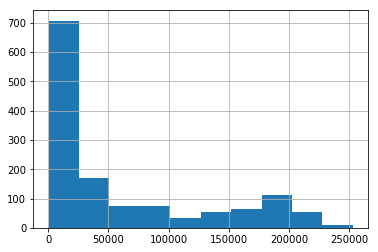

In [34]:
restricted['Final_score'].hist()

In [35]:
restricted = restricted[restricted['Ps_score'] >= 8640]
restricted = restricted[restricted['Stat_score'] >= 3000]
len(restricted)


36

In [36]:
#scored.sort_values(by=['Final_score'], ascending=False).\
restricted.sort_values(by=['Final_score', 'Ps_score', 'Stat_score', 'Pot_score'], ascending=False).\
    head(500).loc[:, 'Group'].to_csv('/home/jesse/top500.csv', index_label='num', sep=' ')

In [37]:
#scored.sort_values(by=['Final_score'], ascending=False)\
restricted.sort_values(by=['Final_score', 'Ps_score', 'Stat_score', 'Pot_score'], ascending=False)\
      .head(90).loc[:, ['Name', 'Ps', 'Ag', 'Dr', 'Ds', 
                                                                         'Sp', 'Co', 'Pw', 'Df', 'Ar', 'Cn', 'Tr', 
                                                                         'BH', 'PH', 'Avg', 'RC_score', 'Final_score', 
                                                                         'pos_stat_score', 'Stat_score', 'Ps_score', 'Pot_score']] 

,Name,Ps,Ag,Dr,Ds,Sp,Co,Pw,Df,Ar,Cn,Tr,BH,PH,Avg,RC_score,Final_score,pos_stat_score,Stat_score,Ps_score,Pot_score
Num,,,,,,,,,,,,,,,,,,,,,
5749,E.Jones,IF,22r,1,2,6,7,6,1,2,1,12,R,R,0.392,841.0,253135.0,18750.0,9375.0,9375.0,10
3925,J.Contreras,P,22r,3,2,1,2,2,1,6,7,15,L,L,0.000,NaN,242110.0,18015.0,9375.0,8640.0,10
1067,B.Lovett,P,20r,6,4,0,1,2,1,9,4,12,R,R,0.000,NaN,236655.0,17310.0,7935.0,9375.0,810
3550,D.Hammond,P,22r,10,2,2,3,1,1,4,6,15,L,L,0.000,NaN,235855.0,17310.0,7935.0,9375.0,10
5418,B.Heibult,P,22r,10,3,0,1,3,1,3,6,14,S,R,0.000,NaN,233290.0,17280.0,8640.0,8640.0,10
7060,M.Orozco,P,22r,7,6,1,1,2,3,7,4,12,L,L,0.000,NaN,233290.0,17280.0,8640.0,8640.0,10
3298,D.Carpenter,P,18r,10,1,1,1,2,1,6,3,9,R,R,0.000,NaN,232660.0,16575.0,7935.0,8640.0,7840
4817,B.Biever,P,20r,9,3,0,1,2,1,6,4,10,S,L,0.000,NaN,225630.0,16575.0,7935.0,8640.0,810
5919,M.Hammond,IF,21r,5,3,4,6,6,3,6,2,15,R,R,0.385,625.0,224980.0,16575.0,7935.0,8640.0,160


In [38]:
scored[scored['Ps'] == 'P'].sort_values(by='Final_score', ascending=False).loc[:, ['Name', 'Final_score', 'Stat_score', 
                                                                                   'ERA', 'OBP_PIT', 'Ps_score', 
                                                                                   'Pot_score']].head(150)

,Name,Final_score,Stat_score,ERA,OBP_PIT,Ps_score,Pot_score
Num,,,,,,,
3925,J.Contreras,242110.0,9375.0,1.41,0.197,8640.0,10
1067,B.Lovett,236655.0,7935.0,2.63,0.251,9375.0,810
3550,D.Hammond,235855.0,7935.0,2.32,0.251,9375.0,10
7060,M.Orozco,233290.0,8640.0,2.14,0.237,8640.0,10
5418,B.Heibult,233290.0,8640.0,1.74,0.210,8640.0,10
3664,E.Crates,233280.0,8640.0,1.71,0.201,8640.0,0
3298,D.Carpenter,232660.0,7935.0,2.64,0.251,8640.0,7840
4817,B.Biever,225630.0,7935.0,2.29,0.255,8640.0,810
3232,P.Daniels,224980.0,7935.0,1.88,0.235,8640.0,160


In [39]:
scored[scored['Name'] == 'A.Riviera']

,2B,3B,AB,Avg,BB_BAT,E,H_BAT,HR_BAT,Hnd_BAT,Name,PA,PM,Ps,RBI,SB,SBA,SO_BAT,BB_PIT,BS,Bt,ER,ERA,G,H_PIT,HR_PIT,Hnd_PIT,IP,L,OBP_PIT,SO_PIT,SV,St,W,Ag,Ar,BH,Cn,Co,Df,Dr,Ds,GP,PH,Pw,Rst,Sp,St_ATT,Tr,Dr_score,Ds_score,Sp_score,Co_score,Pw_score,Df_score,Ar_score,Cn_score,Stat_raw,Stat_score,Ps_raw,Ps_score,Group,AB_avg,AB_score,GP_score,Tr_score,Ag_score,Pot_raw,Pot_score,K_BAT,K_score,OBP_BAT,OBP_score,SB_score,TB,SLG,SLG_score,OPS,OPS_score,RC,RC_score,AVG_BAT,AVG_score,Final_score
Num,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
220,15,0,274,0.292,20,11,80,20,R,A.Riviera,292,200,IF,69,11,17,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21r,1,R,1,6,7,9,2,66,R,6,100,6,66,11,16,1,9,9,9,9,0,0,6109146.0,1215.0,1157.0,9375.0,3,294,274,1089,1,4,4,160,884.353741,484.0,340.136054,256.0,121,155,565.693431,256.0,340.701748,121.0,51.492177,144.0,291.970803,324.0,155365.0
